
Running simulation with Greedy Nearest algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


  0%|          | 0/120.0 [00:00<?, ?it/s]

100%|██████████| 120.0/120.0 [00:00<00:00, 227.13it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 1633
Total Cancelled Rides: 803
Cancellation Rate: 32.95%
Average Waiting Time: 500.42 seconds
Average Trip Time: 984.56 seconds
Average Driver Earnings: $12.50
Average Empty Miles: 2.23 miles
Driver Earnings Gini Coefficient: 0.2095

Running simulation with Hungarian algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 120.0/120.0 [00:00<00:00, 155.61it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 1769
Total Cancelled Rides: 668
Cancellation Rate: 27.41%
Average Waiting Time: 284.05 seconds
Average Trip Time: 953.84 seconds
Average Driver Earnings: $13.24
Average Empty Miles: 0.68 miles
Driver Earnings Gini Coefficient: 0.1935

Running simulation with Stable Matching algorithm...
Initialized simulation with 1000 drivers and 2437 potential trips
Simulation period: 2025-01-01 08:00:00 to 2025-01-01 10:00:00
Riders will automatically cancel after 10 minutes of waiting
Starting simulation at 2025-01-01 08:00:00


100%|██████████| 120.0/120.0 [00:04<00:00, 25.32it/s]


Simulation completed at 2025-01-01 10:00:00

Simulation Results:
Total Completed Trips: 1773
Total Cancelled Rides: 664
Cancellation Rate: 27.25%
Average Waiting Time: 289.11 seconds
Average Trip Time: 953.94 seconds
Average Driver Earnings: $13.28
Average Empty Miles: 0.72 miles
Driver Earnings Gini Coefficient: 0.1950


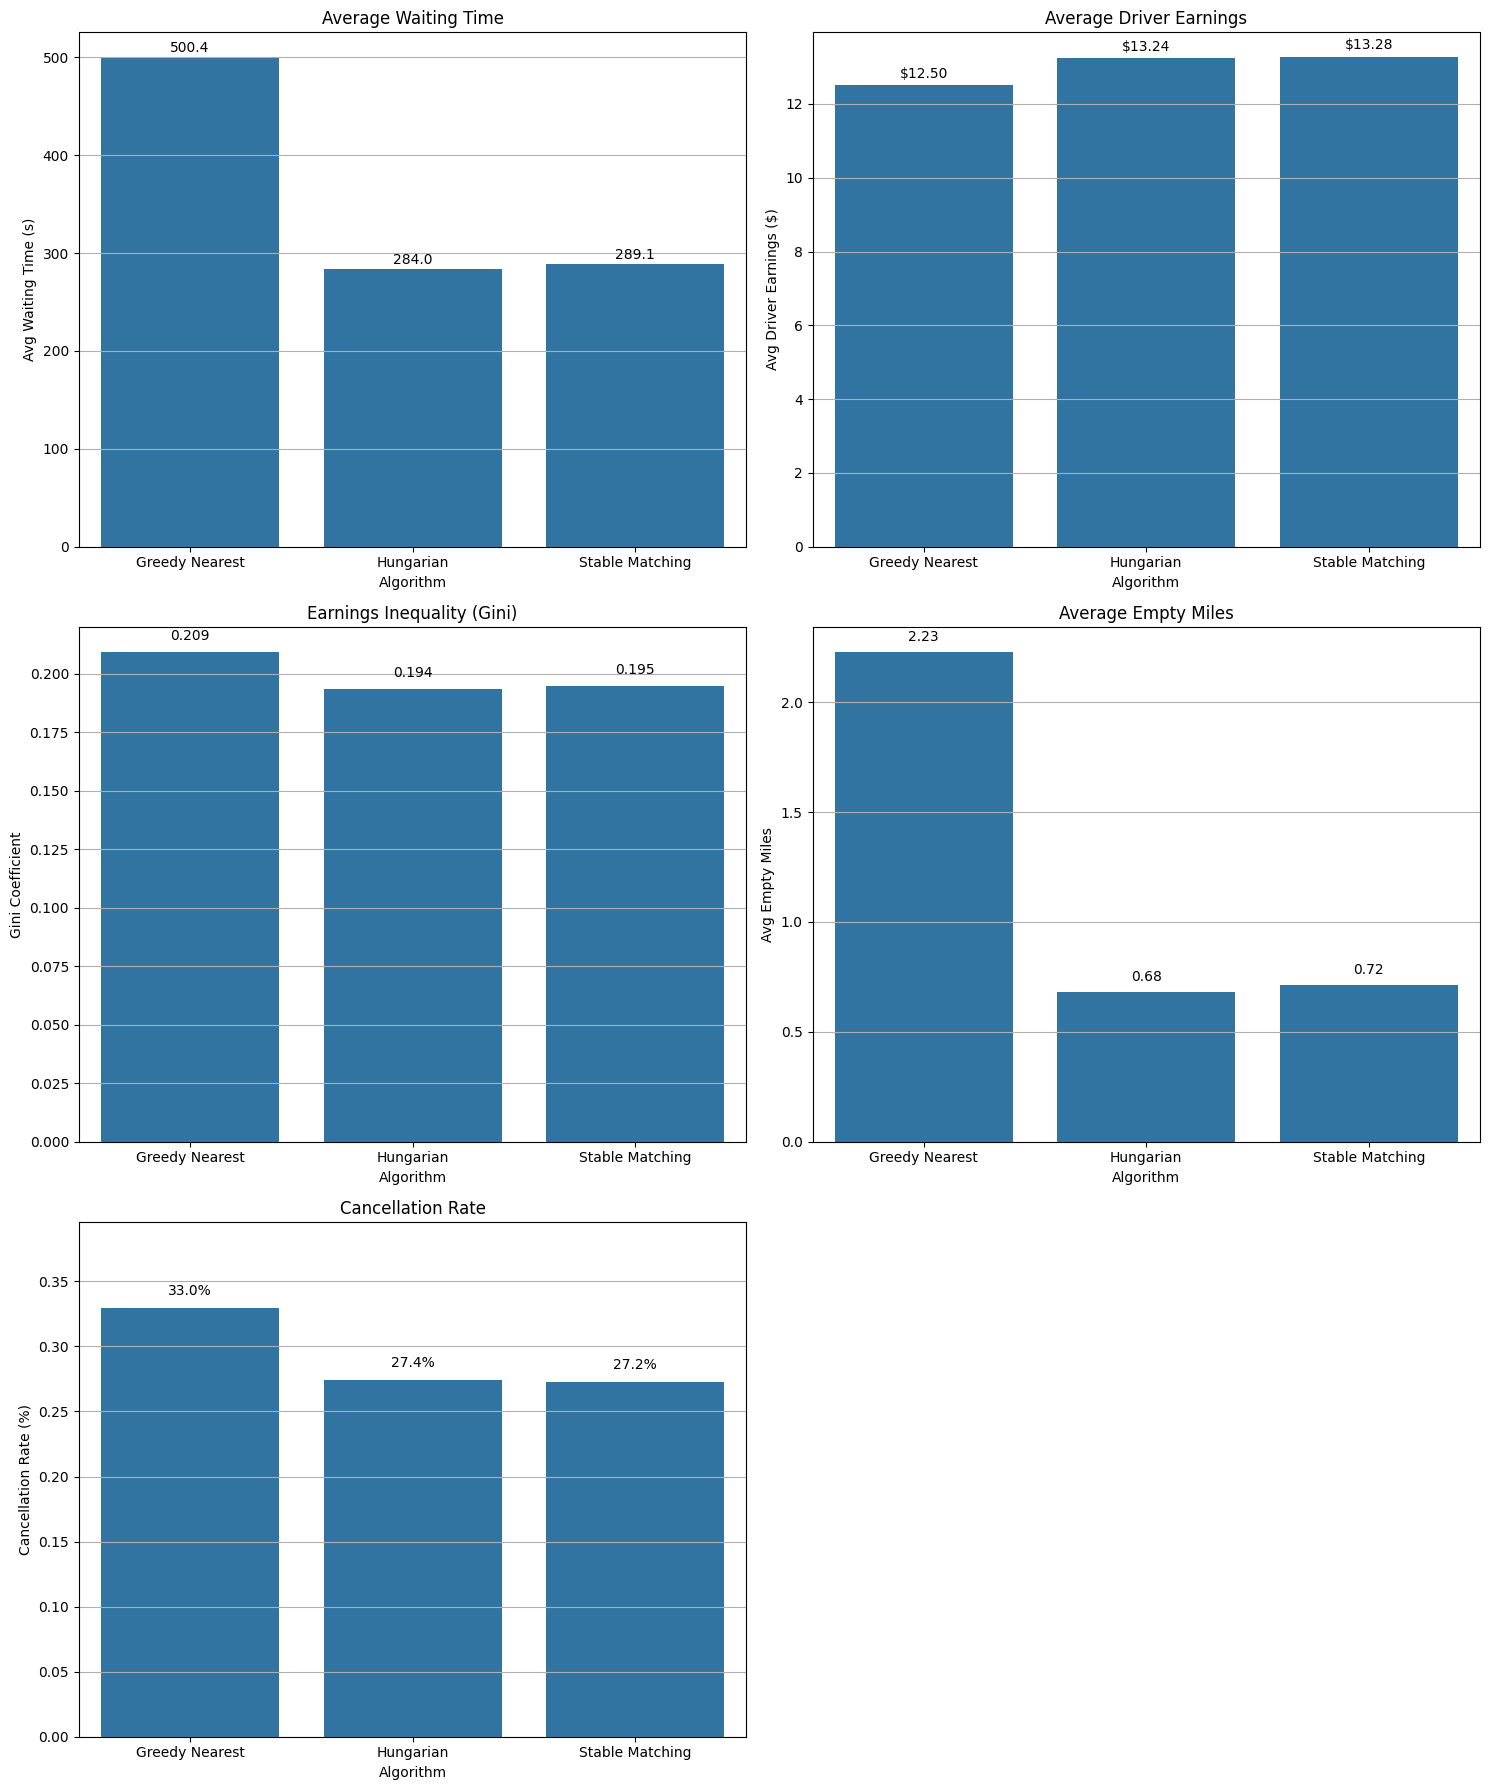


Algorithm Comparison Summary:
-----------------------------
total_completed_trips: Greedy Nearest: 1633.00, Hungarian: 1769.00, Stable Matching: 1773.00
total_cancelled_rides: Greedy Nearest: 803.00, Hungarian: 668.00, Stable Matching: 664.00
cancellation_rate: Greedy Nearest: 0.3295, Hungarian: 0.2741, Stable Matching: 0.2725
avg_waiting_time: Greedy Nearest: 500.42, Hungarian: 284.05, Stable Matching: 289.11
avg_trip_time: Greedy Nearest: 984.56, Hungarian: 953.84, Stable Matching: 953.94
avg_driver_earnings: Greedy Nearest: 12.50, Hungarian: 13.24, Stable Matching: 13.28
avg_empty_miles: Greedy Nearest: 2.23, Hungarian: 0.68, Stable Matching: 0.72
gini_coefficient: Greedy Nearest: 0.2095, Hungarian: 0.1935, Stable Matching: 0.1950
runtime_seconds: Greedy Nearest: 0.53s, Hungarian: 0.77s, Stable Matching: 4.74s


In [2]:
from algorithms import *
from models import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from enviroments import *
import random

def run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date):
    """
    Run comparison of different matching algorithms with consistent driver initialization
    
    Args:
        trip_data_path: Path to trip data
        zone_data_path: Path to zone data
        start_date: Simulation start date
        end_date: Simulation end date
    """
    city = City(zone_data_path)
    trip_df = pd.read_parquet(trip_data_path)
    city.central_zone_id = trip_df['PULocationID'].value_counts().idxmax()
    
    # Define algorithms to test
    algorithms = [
        ('Greedy Nearest', GreedyNearestNeighbor()),
        ('Hungarian', BatchedHungarianAlgorithm()),
        ('Stable Matching', StableMatchingAlgorithm()),
    ]
    
    # Results storage
    all_metrics = []
    algorithm_names = []
    
    # ---------------------------------------
    # Generate consistent driver initialization
    # ---------------------------------------
    
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Get distribution of pickup locations to place drivers
    NUM_DRIVERS = 1000  # Match the value used in Simulation
    
    # Pre-determine driver locations based on pickup distribution
    pickup_dist = trip_df['PULocationID'].value_counts(normalize=True)
    
    # Generate initial driver positions that will be reused
    initial_driver_locations = []
    for i in range(NUM_DRIVERS):
        driver_id = f"D{i:05d}"
        if len(pickup_dist) > 0:
            location_id = np.random.choice(pickup_dist.index, p=pickup_dist.values)
        else:
            location_id = np.random.choice(city.zones['LocationID'].values)
        initial_driver_locations.append((driver_id, location_id))
    
    # Save original driver initialization function
    original_init_drivers = Simulation._initialize_synthetic_drivers
    
    # Override driver initialization with our consistent version
    def consistent_driver_init(self, num_drivers):
        """Create drivers with consistent initial locations across algorithm runs"""
        # Use the pre-determined locations
        for driver_id, location_id in initial_driver_locations:
            self.drivers[driver_id] = Driver(driver_id, location_id)
            
    # Run simulations with each algorithm
    for name, algorithm in algorithms:
        print(f"\nRunning simulation with {name} algorithm...")
        
        # Temporarily override the driver initialization method
        Simulation._initialize_synthetic_drivers = consistent_driver_init
        
        # Initialize simulation
        sim = Simulation(city, algorithm)
        sim.initialize_from_data(
            driver_data_path=None,  # Using synthetic drivers with consistent initialization
            trip_data_path=trip_data_path,
            start_date=start_date,
            end_date=end_date,
            batch_interval_minutes=1,
            max_wait_time_minutes=10,
            num_drivers=NUM_DRIVERS,
        )
        
        # Run simulation and time it
        start_time = time.time()
        sim.run()
        duration = time.time() - start_time
        
        # Store results
        metrics = sim.metrics.copy()
        metrics['runtime_seconds'] = duration
        all_metrics.append(metrics)
        algorithm_names.append(name)
    
    # Restore original driver initialization function
    Simulation._initialize_synthetic_drivers = original_init_drivers
        
    # Compare results
    analyzer = SimulationAnalyzer(sim)  # Use last simulation for analyzer
    analyzer.plot_metrics_comparison(all_metrics, algorithm_names)
    plt.show()
    
    # Additional comparison of key metrics
    print("\nAlgorithm Comparison Summary:")
    print("-----------------------------")
    comparison_df = pd.DataFrame(all_metrics, index=algorithm_names)
    
    # Format and display key metrics
    metrics_to_show = [
        'total_completed_trips', 'total_cancelled_rides', 'cancellation_rate',
        'avg_waiting_time', 'avg_trip_time', 'avg_driver_earnings', 
        'avg_empty_miles', 'gini_coefficient', 'runtime_seconds'
    ]
    
    for metric in metrics_to_show:
        if metric in comparison_df.columns:
            if metric in ['cancellation_rate', 'gini_coefficient']:
                print(f"{metric}: {', '.join([f'{name}: {val:.4f}' for name, val in zip(algorithm_names, comparison_df[metric])])}")
            elif metric == 'runtime_seconds':
                print(f"{metric}: {', '.join([f'{name}: {val:.2f}s' for name, val in zip(algorithm_names, comparison_df[metric])])}")
            else:
                print(f"{metric}: {', '.join([f'{name}: {val:.2f}' for name, val in zip(algorithm_names, comparison_df[metric])])}")


def main():
    # Example paths - replace with actual paths
    trip_data_path = "../data/sample.parquet"
    zone_data_path = "../data/taxi_zones/taxi_zones.shp"
    
    # Define simulation period
    start_date = datetime(2025, 1, 1, 8, 0, 0)  # 8 AM on January 1, 2025
    end_date = datetime(2025, 1, 1, 10, 0, 0)   # 8:30 PM on January 1, 2025
    
    # Run comparison
    run_algorithm_comparison(trip_data_path, zone_data_path, start_date, end_date)


if __name__ == "__main__":
    main()

In [ ]:
from algorithms import *
from models import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from enviroments import *
import random

def analyze_driver_impact(trip_data_path, zone_data_path, start_date, end_date, 
                         driver_counts=[500, 750, 1000, 1250, 1500, 1750, 2000],
                         algorithms=None):
    """
    Analyze the impact of driver count on cancellation rate and other metrics
    
    Args:
        trip_data_path: Path to trip data
        zone_data_path: Path to zone data
        start_date: Simulation start date
        end_date: Simulation end date
        driver_counts: List of driver counts to test
        algorithms: List of tuples (name, algorithm) to test. If None, use default algorithms.
    """
    # Initialize city
    city = City(zone_data_path)
    trip_df = pd.read_parquet(trip_data_path)
    city.central_zone_id = trip_df['PULocationID'].value_counts().idxmax()
    
    # Default algorithms if none provided
    if algorithms is None:
        algorithms = [
            # ('Greedy Nearest', GreedyNearestNeighbor()),
            ('Hungarian', BatchedHungarianAlgorithm()),
            # ('Multi-Object Stable', StableFairMatchingAlgorithm(city, city.central_zone_id, fairness_weight=0.3, centrality_weight=0.2))
        ]
    
    # Results storage structure
    results = {
        alg_name: {
            'driver_counts': [],
            'cancellation_rates': [],
            'completed_trips': [],
            'avg_waiting_time': [],
            'avg_driver_earnings': [],
            'avg_empty_miles': [],
            'gini_coefficient': [],
            'utilization_rate': []  # Measure of driver efficiency
        } for alg_name, _ in algorithms
    }
    
    # Get pickup distribution for driver initialization
    pickup_dist = trip_df['PULocationID'].value_counts(normalize=True)
    
    # For each driver count
    for num_drivers in driver_counts:
        print(f"\nTesting with {num_drivers} drivers...")
        
        # Generate initial driver positions based on pickup distribution
        np.random.seed(42)  # Ensure reproducibility for each algorithm
        random.seed(42)
        
        initial_driver_locations = []
        for i in range(max(driver_counts)):  # Create positions for max driver count
            driver_id = f"D{i:05d}"
            if len(pickup_dist) > 0:
                location_id = np.random.choice(pickup_dist.index, p=pickup_dist.values)
            else:
                location_id = np.random.choice(city.zones['LocationID'].values)
            initial_driver_locations.append((driver_id, location_id))
        
        # Create driver init function using only a subset of the max drivers
        def driver_init_with_count(self, _):
            """Initialize with exactly num_drivers drivers"""
            for i in range(num_drivers):
                driver_id, location_id = initial_driver_locations[i]
                self.drivers[driver_id] = Driver(driver_id, location_id)
        
        # Save original driver initialization function
        original_init_drivers = Simulation._initialize_synthetic_drivers
        
        # Replace with our custom initialization
        Simulation._initialize_synthetic_drivers = driver_init_with_count
        
        # Run each algorithm with this driver count
        for alg_name, algorithm in algorithms:
            print(f"  Running {alg_name}...")
            
            # Initialize simulation
            sim = Simulation(city, algorithm)
            sim.initialize_from_data(
                driver_data_path=None,
                trip_data_path=trip_data_path,
                start_date=start_date,
                end_date=end_date,
                batch_interval_minutes=1,
                max_wait_time_minutes=10,
                num_drivers=num_drivers,  # This will be overridden by our custom init
            )
            
            # Run simulation
            sim.run()
            
            # Extract metrics
            metrics = sim.metrics.copy()
            
            # Calculate utilization rate: what percentage of time were drivers engaged
            total_trip_time = metrics.get('total_trip_time_hours', 0)
            if total_trip_time == 0:
                # Compute from average trip time if not directly available
                avg_trip_time = metrics.get('avg_trip_time', 0)  # in seconds
                total_completed_trips = metrics.get('total_completed_trips', 0)
                total_trip_time = (avg_trip_time * total_completed_trips) / 3600  # convert to hours
                
            total_driver_hours = num_drivers * ((end_date - start_date).total_seconds() / 3600)
            utilization_rate = total_trip_time / total_driver_hours if total_driver_hours > 0 else 0
            
            # Store results
            results[alg_name]['driver_counts'].append(num_drivers)
            results[alg_name]['cancellation_rates'].append(metrics.get('cancellation_rate', 0))
            results[alg_name]['completed_trips'].append(metrics.get('total_completed_trips', 0))
            results[alg_name]['avg_waiting_time'].append(metrics.get('avg_waiting_time', 0) / 60)  # Convert to minutes
            results[alg_name]['avg_driver_earnings'].append(metrics.get('avg_driver_earnings', 0))
            results[alg_name]['avg_empty_miles'].append(metrics.get('avg_empty_miles', 0))
            results[alg_name]['gini_coefficient'].append(metrics.get('gini_coefficient', 0))
            results[alg_name]['utilization_rate'].append(utilization_rate)
    
    # Restore original driver initialization
    Simulation._initialize_synthetic_drivers = original_init_drivers
    
    # Plot results
    plot_driver_optimization_results(results)
    
    # Calculate optimal driver counts based on different criteria
    calculate_optimal_driver_counts(results)
    
    return results

def plot_driver_optimization_results(results):
    """Create visualizations of driver count impact"""
    metrics_to_plot = [
        ('cancellation_rates', 'Cancellation Rate', 'lower'),
        ('completed_trips', 'Completed Trips', 'higher'),
        ('avg_waiting_time', 'Average Waiting Time (min)', 'lower'),
        ('avg_driver_earnings', 'Average Driver Earnings ($)', 'higher'),
        ('avg_empty_miles', 'Average Empty Miles', 'lower'),
        ('gini_coefficient', 'Earnings Gini Coefficient', 'lower'),
        ('utilization_rate', 'Driver Utilization Rate', 'higher')
    ]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 4*len(metrics_to_plot)))
    
    for i, (metric, title, direction) in enumerate(metrics_to_plot):
        ax = axes[i]
        
        for (alg_name, alg_data), color in zip(results.items(), colors):
            ax.plot(
                alg_data['driver_counts'], 
                alg_data[metric],
                'o-',
                label=alg_name,
                color=color
            )
            
        ax.set_title(f"Impact of Driver Count on {title}")
        ax.set_xlabel("Number of Drivers")
        ax.set_ylabel(title)
        ax.grid(True, alpha=0.3)
        
        if metric == 'cancellation_rates':
            ax.set_ylim(bottom=0, top=min(1.0, max([max(data['cancellation_rates']) for data in results.values()]) * 1.1))
            # Format y-axis as percentage
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        if i == 0:  # Only add legend to first plot
            ax.legend()
    
    plt.tight_layout()
    plt.savefig("driver_count_optimization.png")
    plt.show()
    
    # Create elbow plots to find optimal driver counts
    plt.figure(figsize=(12, 8))
    for (alg_name, alg_data), color in zip(results.items(), colors):
        plt.plot(
            alg_data['driver_counts'],
            alg_data['cancellation_rates'],
            'o-',
            label=alg_name,
            color=color
        )
        
        # Add annotation for significant points
        for i, (drivers, rate) in enumerate(zip(alg_data['driver_counts'], alg_data['cancellation_rates'])):
            # Skip some points for clarity
            if i % 2 == 0 or i == len(alg_data['driver_counts']) - 1:
                plt.annotate(
                    f"{drivers}", 
                    (drivers, rate),
                    textcoords="offset points",
                    xytext=(0,5),
                    ha='center'
                )
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.title("Finding Optimal Driver Count (Elbow Method on Cancellation Rate)")
    plt.xlabel("Number of Drivers")
    plt.ylabel("Cancellation Rate")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig("optimal_driver_count_elbow.png")
    plt.show()

def calculate_optimal_driver_counts(results):
    """Calculate optimal driver counts based on different criteria"""
    print("\nOptimal Driver Count Analysis:")
    print("-----------------------------")
    
    for alg_name, data in results.items():
        drivers = data['driver_counts']
        cancel_rates = data['cancellation_rates']
        
        # Find point of diminishing returns (elbow point) for cancellation rate
        # Method: Calculate the normalized rate of improvement
        improvements = []
        for i in range(1, len(drivers)):
            prev_rate = cancel_rates[i-1]
            curr_rate = cancel_rates[i] 
            driver_increase = drivers[i] - drivers[i-1]
            
            improvement = (prev_rate - curr_rate) / driver_increase
            improvements.append(improvement)
        
        # Find where improvement drops significantly
        # (using threshold of 50% of max improvement)
        if improvements:
            threshold = max(improvements) * 0.5
            optimal_idx = next((i for i, imp in enumerate(improvements) if imp < threshold), len(improvements)-1)
            optimal_count = drivers[optimal_idx + 1]  # +1 because improvements index is offset
            
            print(f"\n{alg_name}:")
            print(f"  Optimal driver count based on cancellation rate: {optimal_count}")
            print(f"  Cancellation rate at optimal count: {cancel_rates[optimal_idx + 1]:.2%}")
            print(f"  Cancellation rate reduction compared to minimum drivers: {(cancel_rates[0] - cancel_rates[optimal_idx + 1]):.2%}")
            
            # Also find count where cancellation rate drops below certain thresholds
            thresholds = [0.20, 0.15, 0.10, 0.05]
            for threshold in thresholds:
                try:
                    idx = next((i for i, rate in enumerate(cancel_rates) if rate <= threshold), None)
                    if idx is not None:
                        print(f"  Drivers needed for cancellation rate ≤ {threshold:.0%}: {drivers[idx]}")
                    else:
                        print(f"  Cancellation rate never drops below {threshold:.0%} with tested driver counts")
                except:
                    print(f"  Error calculating threshold for {threshold:.0%}")
        else:
            print(f"\n{alg_name}: Insufficient data to calculate optimal driver count")

def main():
    # Example paths - replace with actual paths
    trip_data_path = "../data/half_day.parquet"
    zone_data_path = "../data/taxi_zones/taxi_zones.shp"
    
    # Define simulation period - using 6 hours instead of full day for faster testing
    start_date = datetime(2025, 1, 1, 0, 0, 0)  # 0 AM
    end_date = datetime(2025, 1, 1, 14, 0, 0)   # 2 PM
    
    # Define driver counts to test
    driver_counts = [1000, 2500, 5000, 10000, 15000, 20000, 30000]
    
    # Run analysis
    results = analyze_driver_impact(
        trip_data_path, 
        zone_data_path, 
        start_date, 
        end_date,
        driver_counts=driver_counts
    )
    
    # Create summary table
    print("\nSummary Table of Cancellation Rates:")
    print("-----------------------------------")
    
    # Column headers
    print(f"{'Algorithm':<20} | " + " | ".join(f"{count:>5}" for count in driver_counts))
    print("-" * (20 + 8 * len(driver_counts)))
    
    # Data rows
    for alg_name, data in results.items():
        rates = [f"{rate:.1%}" for rate in data['cancellation_rates']]
        print(f"{alg_name:<20} | " + " | ".join(f"{rate:>5}" for rate in rates))
    
    # Create summary table for average waiting times
    print("\nSummary Table of Average Waiting Times (minutes):")
    print("----------------------------------------------")
    
    # Column headers
    print(f"{'Algorithm':<20} | " + " | ".join(f"{count:>5}" for count in driver_counts))
    print("-" * (20 + 8 * len(driver_counts)))
    
    # Data rows
    for alg_name, data in results.items():
        times = [f"{time:.1f}" for time in data['avg_waiting_time']]
        print(f"{alg_name:<20} | " + " | ".join(f"{time:>5}" for time in times))
    
    # Create summary table for average driver earnings
    print("\nSummary Table of Average Driver Earnings ($):")
    print("------------------------------------------")
    
    # Column headers
    print(f"{'Algorithm':<20} | " + " | ".join(f"{count:>5}" for count in driver_counts))
    print("-" * (20 + 8 * len(driver_counts)))
    
    # Data rows
    for alg_name, data in results.items():
        earnings = [f"{earning:.2f}" for earning in data['avg_driver_earnings']]
        print(f"{alg_name:<20} | " + " | ".join(f"{earning:>5}" for earning in earnings))

if __name__ == "__main__":
    main()